In [59]:
import numpy as np # библиотека для работы с чиселками
import pandas as pd # data processing, работа с CSV файлами
import matplotlib.pyplot as plt # для графики

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

Откроем датасет и посмотрим первые 5 его строчек

In [60]:
dataset = pd.read_csv('..\\..\\tasks\\lab1\\dataset\\lab1-07.csv', header=None)
dataset.head(5)

,0,1
0,1.404040,-12.034654
1,3.222222,-1.565204
2,4.515152,-0.025646
3,1.646465,-11.261848
4,5.646465,-0.593668


### Посмотрим датасет

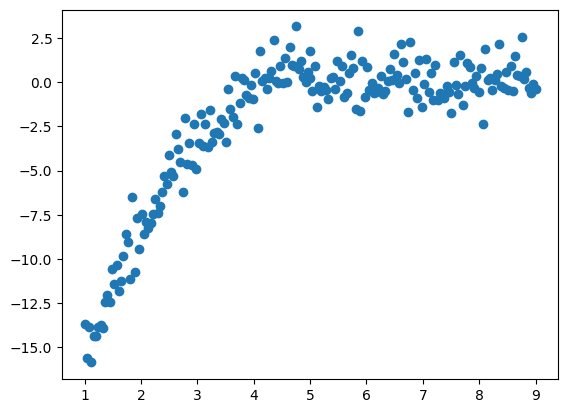

In [61]:
plt.scatter(dataset[0], dataset[1])

Как видно из диаграммы рассеяния, данные представляют собой кривую насыщения (A - B*exp(-kx)). 

### Подготовим данные

Разделим датасет на обучающую и тестовую выборку в соотношении 4:1

In [62]:
X_train, X_test, y_train, y_test = train_test_split(dataset[0].to_frame(), dataset[1], test_size=0.2, random_state=42)

### Посмотрим на работу линейной регрессии

Обучим модель Linear regression

In [63]:
model_regression = LinearRegression()

model_regression.fit(X_train, y_train)

LinearRegression()

Оценим работу

In [64]:
train_predict_regression = model_regression.predict(X_train)
test_predict_regression = model_regression.predict(X_test)

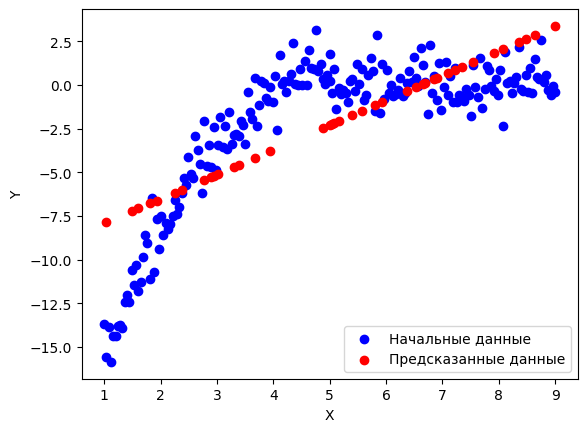

In [65]:
plt.scatter(dataset[0], dataset[1], color='blue', label='Начальные данные')
plt.scatter(X_test, test_predict_regression, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [66]:
# Расчет метрик
train_mse_regression = mean_squared_error(y_train, train_predict_regression)
train_mae_regression = mean_absolute_error(y_train, train_predict_regression)

test_mse_regression = mean_squared_error(y_test, test_predict_regression)
test_mae_regression = mean_absolute_error(y_test, test_predict_regression)



print('Метрика:          MSE            MAE')
print('Train', train_mse_regression, train_mae_regression)
print('Test', test_mse_regression, test_mae_regression)

Метрика:          MSE            MAE
Train 8.130377816703561 2.353069764836676
Test 7.047462514179974 2.079107800557874


### Вывод:
Как видно из диаграммы рассеяния, линейная регрессия плохо подходит для данного набора данных.
Значения MSE (8.13 / 7.04) и MAE (2.35 / 2.07) достаточно высоки, что свидетельствует о значительных ошибках в предсказаниях модели, что логично, ведь простая линейная регрессия пытается аппроксимировать кривую насыщения прямой линией.

### Улучшение бейзлайна

Т. к. данные имеют зависимость в виде кривой насыщения, попробуем создать линейные признаки, чтобы линейная регрессия могла их использовать

In [67]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [68]:
# Функция для создания признака exp(-k*x)
def exp_feature(x, k=1.0):
    return np.exp(-k * x)

# Pipeline с трансформером и линейной регрессией
pipeline = Pipeline([
    ("exp", FunctionTransformer(func=lambda X: exp_feature(X, k=1.0), validate=False)),
    ("linreg", LinearRegression())
])

# Сеточный поиск по k
param_grid = {"exp__func": [lambda X, k=k: exp_feature(X, k) for k in np.linspace(0.01, 2, 200)]}
grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Лучший параметр k подобран автоматически через GridSearchCV.")

# Извлечение коэффициентов
A = best_model.named_steps["linreg"].intercept_
B = -best_model.named_steps["linreg"].coef_[0]
print("A =", A)
print("B =", B)

Лучший параметр k подобран автоматически через GridSearchCV.
A = 0.5773568368488715
B = 37.66311497454749


Оценим работу

In [79]:
train_predict_regression = A - B * best_model.named_steps["exp"].transform(X_train)
test_predict_regression = A - B * best_model.named_steps["exp"].transform(X_test)

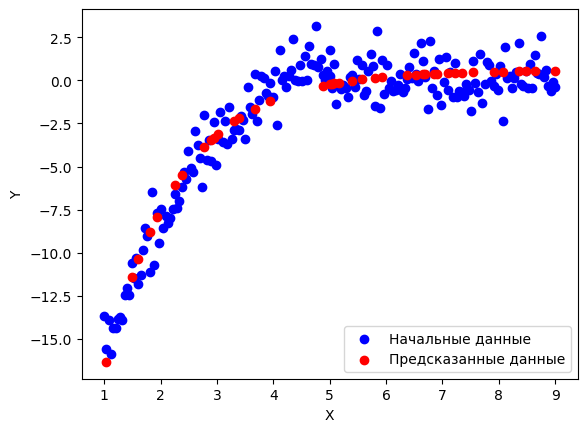

In [80]:
plt.scatter(dataset[0], dataset[1], color='blue', label='Начальные данные')
plt.scatter(X_test, test_predict_regression, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [71]:
# Расчет метрик
train_mse_regression = mean_squared_error(y_train, train_predict_regression)
train_mae_regression = mean_absolute_error(y_train, train_predict_regression)

test_mse_regression = mean_squared_error(y_test, test_predict_regression)
test_mae_regression = mean_absolute_error(y_test, test_predict_regression)



print('Метрика:          MSE            MAE')
print('Train', train_mse_regression, train_mae_regression)
print('Test', test_mse_regression, test_mae_regression)

Метрика:          MSE            MAE
Train 1.3371825755537106 0.9272723524863202
Test 1.251725088637151 0.9121469428966027


### Вывод:
Как видно из диаграммы рассеяния, этот подход лучше работает с предоставленными данными.
Ошибки уменьшились в несколько раз, что показывает значительное улучшение качества модели. Учет экспоненциального признака и подбор оптимального параметра k позволяют построить насыщающую кривую, которая гораздо точнее описывает данные.